In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_boston

import seaborn as sns

In [3]:
# Load Boston Housing Dataset
from sklearn.datasets import load_boston
boston_data = load_boston()

# Transform Dataset to Dataframe
boston = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
boston['MEDV'] = boston_data.target

# Check for Dataset Description
print(boston_data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

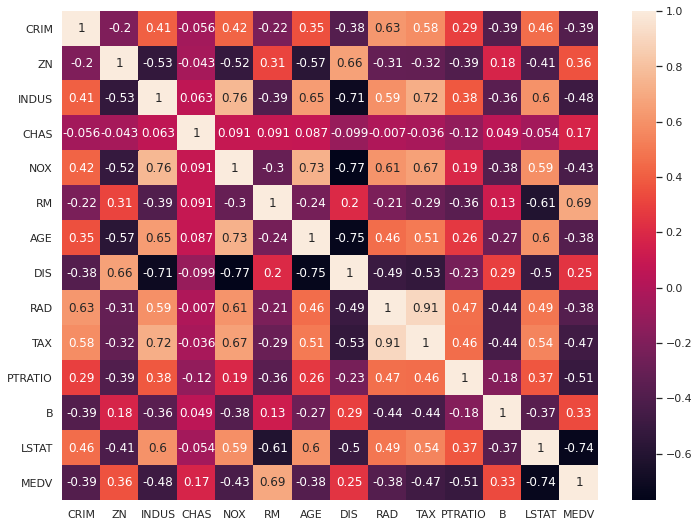

In [ ]:
# Check for Correlation of Features
sns.set(rc={'figure.figsize': (12, 9)})
corr_matrix = boston.corr().round(3)
sns.heatmap(data=corr_matrix, annot=True)
# Correlation coefficient ranges from -1 to 1 with 1 (-1) having
# a strong positive (negative) correlation


Based on the correlation matrix, *LSTAT* and *RM* shows a higher +/- correlation with the MEDV.

Another interesting feature is the high negative correlation of the *AGE* of the houses and the *DIS* to the 5 Boston employment centers. This may denote that new houses are built farther from the employment centers (which makes sense, btw).

*DIS* also shows a strong negative correlation with NOX concentration and INDUS proportion of non-retail business acres per town. I'm guessing this is an interesting feature assuming that the employment centers are where most of the concentration of *NOX* will be and that the farther you are from the employment center, the more non-retail businesses will appear.

TAX feature also shows an interesting correlation with *RAD*, *NOX*, and *INDUS*

For this project, if we set the minimum correlation required to be a feature to .50, then we will have the following features [**RM, LSTAT, PTRATIO**] can affect the price of the houses. We can also explore the inclusion of the other features such as *TAX* and *DIST* and check if our model improves its prediction capability.

In [ ]:
# Create a function to get Correlated feature data with a threshold
def getCorrelatedFeature(corrdata, threshold):
  feature = []
  value = []

  for i, index in enumerate(corrdata.index):
    if abs(corrdata[index]) > threshold:
      feature.append(index)
      value.append(corrdata[index])
  
  df = pd.DataFrame(data = value, index = feature, columns = ['Corr Value'])
  return df

In [ ]:
# Correlated Features with threshold greater than 0.5
corr_value = getCorrelatedFeature(corr_matrix['MEDV'], 0.5)
corr_value

,Corr Value
RM,0.695
PTRATIO,-0.508
LSTAT,-0.738
MEDV,1.000


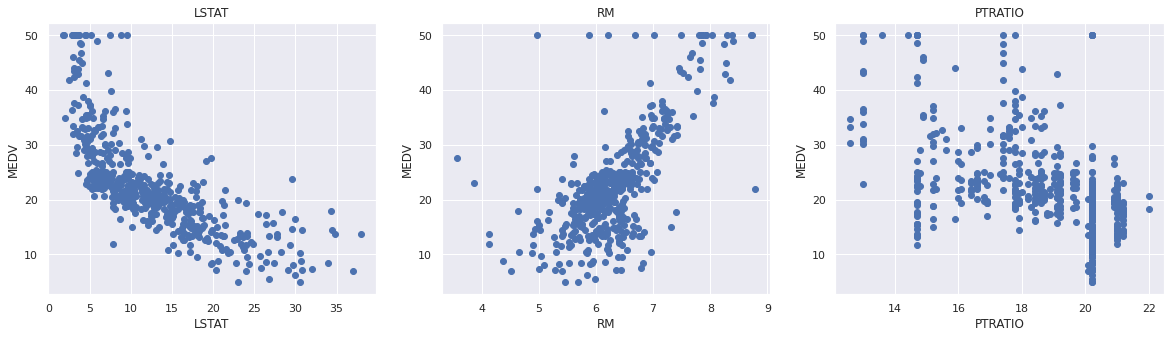

In [ ]:
# Scatter plot of selected features
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM','PTRATIO']
target = boston['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')
plt.show()

**Before we select relevant features (X_features), let's create a mode using all the feature sets as a baseline**

In [4]:
# Perform Linear Regression using all features
X_all = boston.drop(['MEDV'], axis = 1)
y = boston['MEDV']

# Split the dataset to Training and Test
Xtrain, Xtest, ytrain, ytest = train_test_split(X_all,y, test_size = 0.25, random_state = 4)
#Xtrain, Xtest, ytrain, ytest = train_test_split(X_features,y, test_size = 0.25, random_state = 4)

# Scaling dataset
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain_sc = scaler.transform(Xtrain)
Xtest_sc = scaler.transform(Xtest)

# Creating Linear Regressor
clr = skl.LinearRegression().fit(Xtrain_sc, ytrain)
print('intercept:',clr.intercept_)
print('coefficients:', clr.coef_)

# Train the Model
ypred_train = clr.predict(Xtrain_sc)
ypred_test = clr.predict(Xtest_sc)

# Getting Cross Validation Score using 10 folds
#cvlinear = cross_val_score(estimator = clr, X = X_all, y = y, cv=10)

# R2 and MSE Scores for Train and Test sets
R2_test = R2(ytest, ypred_test)
MSE_test = MSE(ytest, ypred_test)
R2_train = R2(ytrain, ypred_train)
MSE_train = MSE(ytrain, ypred_train)

print('---------------')
print('Ordinary Least Squares')
#print('CV:', cvlinear.mean())
print('MSE Test:', MSE_test)
print('R2 Test:', R2_test)
print('MSE Train:', MSE_train)
#print('R2 Train:', R2_train)

intercept: 22.085488126649086
coefficients: [-1.03641096  1.14957288 -0.07334764  0.83774594 -1.79262617  2.37466102
 -0.16358045 -3.19362981  2.97591582 -2.57577035 -1.87929764  0.80956493
 -3.54055551]
---------------
Ordinary Least Squares
MSE Test: 26.951425624235785
R2 Test: 0.73138165231484
MSE Train: 20.54926467081804


The model using all the features yield an MSE Train: 20.54926467081804 and MSE Test: 26.95142562423577. The R2 value is 0.7313816523148402.

Plotting the predicted values(+) does not show a good fit with the actual values. We can try performing linear regression using the selected features and check for scores.

In [ ]:
# Using a polynomial Model
maxdegree = 2

# Polynomial Model
polyreg = PolynomialFeatures(degree = maxdegree)
Xpoly = polyreg.fit_transform(Xtrain_sc)
polyreg.fit(Xpoly, ytrain)

# Regression
plr = skl.LinearRegression().fit(Xpoly, ytrain)

# Predictions
polypred_test = plr.predict(polyreg.fit_transform(Xtest_sc))

# Checking for CV score
cvpoly = cross_val_score(estimator = plr, X = Xtrain_sc, y = ytrain, cv = 10)

# Checking for MSE and R2 scores
plr_R2 = R2(ytest, polypred_test)
plr_mse = MSE(ytest, polypred_test)

print('---------------')
print('Polynomial Model')
print('CV:', cvpoly.mean())
print('MSE Test:', plr_mse)
print('R2 Test:', plr_R2)

---------------
Polynomial Model
CV: 0.710192320433823
MSE Test: 14.866176488765435
R2 Test: 0.8518324106307317


Using a polynomial model of degree 2 improves the MSE and R2 accuracy of our prediction. Increasing the complexity of to degree = 3 yields a very high MSE and R2 scores. We can conclude that degree = 2 is the best possible polynomial complexity that we can use.

Polynomial degree: 0
MSE by StandardScaler: 37.13180746769891
MSE by MinMaxScaler: 37.13180746769891
Polynomial degree: 1
MSE by StandardScaler: 138.84144536815492
MSE by MinMaxScaler: 154.02013753073896


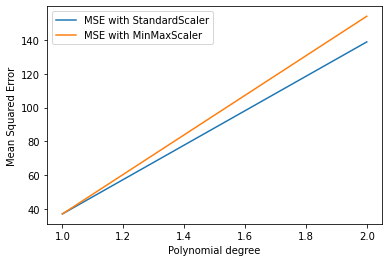

In [12]:
#Linear regression with CV where different scaler packages applied.
degree=2
polydegree=np.zeros(degree)
poly_MSE=np.zeros(degree)
poly_MSE2=np.zeros(degree)
for i in range (0,degree):
    poly=PolynomialFeatures(i+1)
    design_X =poly.fit_transform(X_all)
    #cross validation
    k=5
    kfold=KFold(n_splits = k)
    scores_KFold1 = np.zeros((k))
    scores_KFold2 = np.zeros((k))
    polydegree[i]=i+1
    j=0
    for train_inds, test_inds in kfold.split(design_X):
        design_X_train = design_X[train_inds]
        Y_train = y[train_inds]

        design_X_test = design_X[test_inds]
        Y_test=y[test_inds]

        #scaling in each fold with standard scaler
        scaler = StandardScaler()  # substract the mean value of each column an divides by it's std dev
        scaler.fit(design_X_train)
        design_X_train_scaled1 = scaler.transform(design_X_train)
        design_X_test_scaled1 = scaler.transform(design_X_test)

        #scaling in each fold with minmax scaler
        scaler2 = MinMaxScaler()
        scaler2.fit(design_X_train)
        design_X_train_scaled2 = scaler2.transform(design_X_train)
        design_X_test_scaled2 = scaler2.transform(design_X_test)
        # linear regression
        clf1=skl.LinearRegression().fit(design_X_train_scaled1,Y_train)
        Y_fit_predict=clf1.predict(design_X_test_scaled1)
        ##
        clf2 = skl.LinearRegression().fit(design_X_train_scaled2, Y_train)
        Y_fit_predict2 = clf2.predict(design_X_test_scaled2)
        ##
        scores_KFold1[j] = np.sum((Y_fit_predict - Y_test)**2)/np.size(Y_fit_predict)
        scores_KFold2[j] = np.sum((Y_fit_predict2 - Y_test) ** 2) / np.size(Y_fit_predict2)
        j += 1

    estimated_mse_KFold = np.mean(scores_KFold1)
    estimated_mse_KFold2 = np.mean(scores_KFold2)
    poly_MSE[i]=estimated_mse_KFold
    poly_MSE2[i]=estimated_mse_KFold2
    print('Polynomial degree:',i)
    print('MSE by StandardScaler:', poly_MSE[i])
    print('MSE by MinMaxScaler:',poly_MSE2[i])

plt.plot(polydegree, poly_MSE, label='MSE with StandardScaler')
plt.plot(polydegree, poly_MSE2, label='MSE with MinMaxScaler ')
plt.legend()
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
# Using Ridge RegressionCV
lamda = 2
nlambdas = 100
lambdas = np.logspace(-3, 0, nlambdas)

poly = PolynomialFeatures(degree = maxdegree)
Xpoly = poly.fit_transform(X_all)
#Xpoly = poly.fit_transform(X_features)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xpoly, y, test_size = 0.25, random_state = 4)

scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrainsc = scaler.transform(Xtrain)
Xtestsc = scaler.transform(Xtest)

#clrr = skl.Ridge(alpha=lamda).fit(Xtrainsc, ytrain)
clrr = skl.RidgeCV(alphas = lambdas).fit(Xtrainsc, ytrain)

# Predictions
polypred_test = clrr.predict(Xtestsc)

# Checking for CV score
cvpolyR = cross_val_score(estimator = clrr, X = Xtrainsc, y = ytrain.ravel(), cv = 10)

# Checking for MSE and R2 scores
clrr_R2 = R2(ytest, polypred_test)
clrr_mse = MSE(ytest, polypred_test)

print('---------------')
print('Ridge Regression')
print('CV:', cvpolyR.mean())
print('MSE Test:', clrr_mse)
print('R2 Test:', clrr_R2)

---------------
Ridge Regression
CV: 0.8119429083037877
MSE Test: 13.384537596797816
R2 Test: 0.8665995475004236


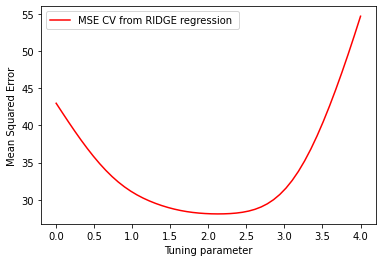

In [6]:
# Using Ridge RegressionCV with varied lamda
nlambdas = 100
lambdas = np.logspace(-3, 0, nlambdas)

maxdegree=2
poly = PolynomialFeatures(degree = maxdegree)
Xpoly = poly.fit_transform(X_all)
#Xpoly = poly.fit_transform(X_features)

#determining the number of folds
k = 5
kfold = KFold(n_splits=k)
scores_KFold = np.zeros((k))
#determining the lambdas
nlambdas = 50 #number of lambdas
lambdas = np.logspace(0, 4, nlambdas)
lambda_MSE=np.zeros(nlambdas)
lambda_comp = np.zeros(nlambdas)
i=0
for i in range (0,nlambdas):
    ridge = Ridge(alpha=lambdas[i])
    j=0
    for train_inds, test_inds in kfold.split(Xpoly):
        Xpoly_train = Xpoly[train_inds]
        Y_train = y[train_inds]

        Xpoly_test = Xpoly[test_inds]
        Y_test=y[test_inds]

        #scaling in each fold
        scaler = StandardScaler()  # substract the mean value of each column an divides by it's std dev
        scaler.fit(Xpoly_train)
        Xpoly_train_scaled = scaler.transform(Xpoly_train)
        Xpoly_test_scaled = scaler.transform(Xpoly_test)

        # RIDGE
        ridge.fit(Xpoly_train_scaled,Y_train)
        Yfit_predict=ridge.predict(Xpoly_test_scaled)
        scores_KFold[j] = np.sum((Yfit_predict - Y_test)**2)/np.size(Yfit_predict)
        j += 1

    estimated_mse_KFold = np.mean(scores_KFold)
    lambda_MSE[i]=estimated_mse_KFold


plt.plot(np.log10(lambdas), lambda_MSE, 'r',label='MSE CV from RIDGE regression ')
plt.legend()
plt.xlabel('Tuning parameter')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
# MSE and R2 Comparison of OLS, Polynomial(degree=2), and Ridge Regression
# using all Features
print('---------------')
print('Ordinary Least Squares')
print('CV:', cvlinear.mean())
print('MSE Test:', MSE_test)
print('R2 Test:', R2_test)
print('---------------')
print('Polynomial Model')
print('CV:', cvpoly.mean())
print('MSE Test:', plr_mse)
print('R2 Test:', plr_R2)
print('---------------')
print('Ridge Regression')
print('CV:', cvpolyR.mean())
print('MSE Test:', clrr_mse)
print('R2 Test:', clrr_R2)

---------------
Ordinary Least Squares
CV: 0.20252899006055802
MSE Test: 26.951425624235785
R2 Test: 0.73138165231484
---------------
Polynomial Model
CV: 0.710192320433823
MSE Test: 14.866176488765435
R2 Test: 0.8518324106307317
---------------
Ridge Regression
CV: 0.8119429083037877
MSE Test: 13.384537596797816
R2 Test: 0.8665995475004236


Trying the Ridge Regression using only the selected features.

In [ ]:
features = boston_data.feature_names
X_features = boston[['RM','LSTAT', 'PTRATIO', 'TAX', 'DIS']]
#X_features = boston[['RM','LSTAT', 'PTRATIO', 'TAX']]
#X_features = boston[['RM','LSTAT', 'PTRATIO']]
#X_features = boston[['RM','LSTAT']]
#X_features = boston[features]

boston.corr()['MEDV'][:]

CRIM      -0.388305
ZN         0.360445
INDUS     -0.483725
CHAS       0.175260
NOX       -0.427321
RM         0.695360
AGE       -0.376955
DIS        0.249929
RAD       -0.381626
TAX       -0.468536
PTRATIO   -0.507787
B          0.333461
LSTAT     -0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

alpha: 0.1519911082952933
coef: [  0.          12.98293362   2.16367041   8.99252635   2.81603149
 -10.62633814   0.16480995  -5.69732368  -7.80340802 -11.7220527
   5.0438802    6.24462218  -2.28852947  -9.2960419    1.62450463
  -5.68381522  12.94312595   2.13240655   2.17855835  -0.94010106
   1.97690959]
intercept: 22.08548812664898
---------------
Ridge Regression
CV: 0.7904009753321446
MSE Test: 12.904405820488742
R2 Test: 0.8713849049142187


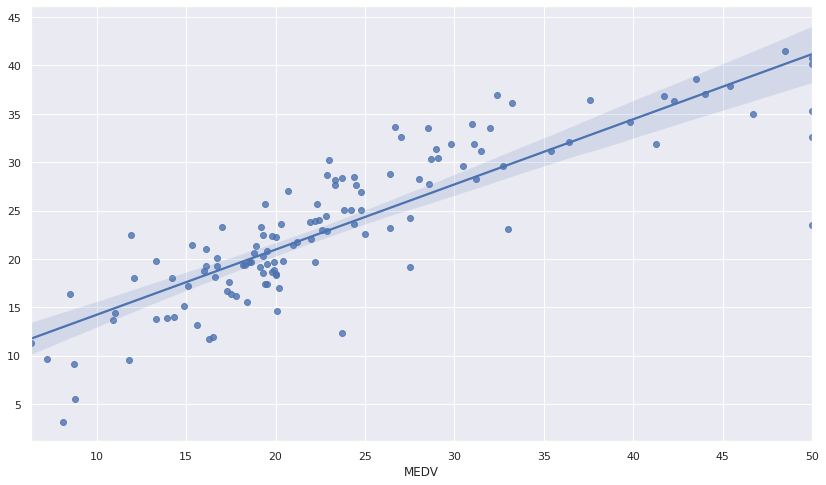

In [ ]:
# Using Ridge RegressionCV
nlambdas = 100
lambdas = np.logspace(-3, 0, nlambdas)
maxdegree = 2

poly = PolynomialFeatures(degree = maxdegree)
#Xpoly = poly.fit_transform(X_all)
Xpoly = poly.fit_transform(X_features)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xpoly, y, test_size = 0.25, random_state = 4)

scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrainsc = scaler.transform(Xtrain)
Xtestsc = scaler.transform(Xtest)

#clrr = skl.Ridge(alpha=lamda).fit(Xtrainsc, ytrain)
clrr = skl.RidgeCV(alphas = lambdas).fit(Xtrainsc, ytrain)
print('alpha:',clrr.alpha_)
print('coef:', clrr.coef_)
print('intercept:', clrr.intercept_)

# Predictions
polypred_test = clrr.predict(Xtestsc)

# Checking for CV score
cvpolyR = cross_val_score(estimator = clrr, X = Xtrainsc, y = ytrain.ravel(), cv = 10)

# Checking for MSE and R2 scores
clrr_R2 = R2(ytest, polypred_test)
clrr_mse = MSE(ytest, polypred_test)

print('---------------')
print('Ridge Regression')
print('CV:', cvpolyR.mean())
print('MSE Test:', clrr_mse)
print('R2 Test:', clrr_R2)

plt.figure(figsize=[14,8])
sns.regplot(x = ytest, y = ypred_test, ci = 95)

Using different number of features to train the model, it was observed that the MSE of the prediction increases as you increase the number of features used. The best combination so far is the model that uses at least 5 different features.